# BigDIPA 2017:  Spatial Statistics with Python

**A tutorial using Python to calculate spatial statistics.**

By [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)<br/>
Department of Computer Science
University of California, Irvine

September 20, 2017

## Outline
-------------------------
Point processes are quite general models of points in space and/or time and are useful for analyzing a range of observed phenomenom.  In this lab, we study three types of processes: homogeneous and non- Poisson Processes, clustering processes, and repellant processes.  We also cover how to compute so-called G-statistics for a point process in order to test if the points are uniform, clustered, or repellant.   

The lab consists of three parts:
### Part 1:  Model Definitions
- Define Poisson process and simulate data from one.
- Define clustering and repellant processes as extensions of a Poisson process.  
- Plot data from various processes.

### Part 2:  Testing for Process Type 
- Define and calculate the G statistic.
- Implement replication to gague uncertainty.

### Part 3:  Application to Protein Data
- Load and visualize protein dataset
- Test if points exhibit cohesion, repulsion, or neither.

## References
----------------------------------
[Analysing spatial point patterns in R](http://www2.stat.unibo.it/bruno/dati%20spaziali%200809/spatialpointpatterns.pdf) : Description and implementation in R of the discussed methods. 

## Import Packages
-----------------------------

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#  PART 1:  Point Process Models
--------------------

For a product space $\mathcal{X} \times \mathcal{Y}$, define a Poisson process over the space as:

$$n \sim Poisson(\lambda_{0} \mid \mathcal{X} \times \mathcal{Y} \mid)$$ 

$$u_{i} \sim Uniform(\mathcal{X} \times \mathcal{Y}) \ \ \ for \ \ i \in [1, n]$$

where $\mid \mathcal{X} \times \mathcal{Y} \mid$ denotes the volume of the space.  In words, we first sample $n$ points from a Poisson distribution whose intensity is the base intensity $\lambda_{0}$ scaled by the volume of the space.  Notice that the Poisson intensity paramter, $\lambda_{0}$, is fixed across the space.  Thus we call the process **homogeneous**.  If $\lambda$, rather, varies according to some function $\lambda = f(x,y)$, we call the process **non-homogeneous**.  Next we'll implement a function that can sample from both types of processes.      

## 1.1  Sample from a Poisson Process

In [6]:
# 10 X 10 
nX = 10
nY = nX

# Generate the same data by setting the seed
np.random.seed(135)

def sample_from_poisson_process(intensity=1., nonhomog_fn=None, area_min=0., area_max=nX, step_size=1.):
    
    ### Homogeneous process
    if nonhomog_fn is None:
        # draw uniformly over the area
        n = np.random.poisson(intensity * (area_max-area_min)**2)
        return np.random.uniform(low=area_min, high=area_max, size=(n,2))
    
    ### Non-Homogenous process defined by nonhomog_fn(x, y, step_size)
    else:
        sample_aggregator = []
        # for simplicity, we'll simulate from a patch work of homogenous PPs
        for y in np.arange(area_min, area_max, step_size):
            for x in np.arange(area_min, area_max, step_size):
                
                samples = sample_from_poisson_process(nonhomog_fn(x, y, step_size), area_min=0., area_max=step_size)
                samples[:,0] = samples[:,0] + x
                samples[:,1] = samples[:,1] + y
                sample_aggregator.append(samples)
                
        return np.vstack(sample_aggregator)    

The above function defines the non-homogeneous process via a discrete patchwork of homogeneous ones.  We did this for simplicity, but more sophisticated techniques, such as [Gaussian Processses](https://hips.seas.harvard.edu/files/adams-sgcp-icml-2009.pdf), can be used to define the intensity as a continuous function.  

## 1.2  Plot Non- and Homogeneous Processes

First, let's define a function for the non-homogenous process.

In [7]:
def intensity_fn(x, y, step_size):
    if x == y:
        return 25.
    else:
        return 1.

Simulate data from both types of Poisson processes.

In [8]:
x_homog_pp = sample_from_poisson_process(intensity=5.)
x_nonhomog_pp = sample_from_poisson_process(nonhomog_fn=intensity_fn)

Plot the two processes.

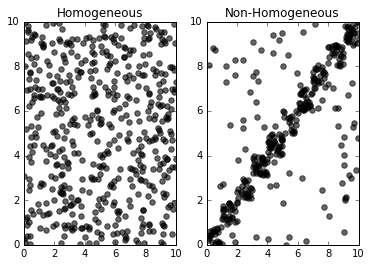

In [9]:
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(x_homog_pp[:,0], x_homog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(x_nonhomog_pp[:,0], x_nonhomog_pp[:,1], s=30, color='black', alpha=0.6)
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.title("Non-Homogeneous")

plt.show()

## 1.3  Poisson Cluster Process

Notice that the Poisson process---both types---samples points independently.  Even in the non-homogeneous type, the intensity depends on the location in space, and the points are conditionally independent, given the location.  Next we look at point processes with inter-point dependence.  Define a *Poisson cluster process*, with parameters $\lambda_{0}$, $\lambda_{1}$, and $\sigma_{0}$, as follows: 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ n_{i} \sim Poisson(\lambda_{1}) $$
$$ \{ u_{i,j} \} \sim \text{Normal}(\mu=u_{i}, \sigma_{0}) \ \ \ for \ \ j \in [1, n_{i}]$$

The final sample set consists of both the parent and child points: $ \{ \{ u_{i} \}, \{ u_{i,j} \} \} $.  In words, this process simply samples points from a homogeneous Poisson process, and then for each sampled point, it samples child point from a Normal distribution centered at the parent point.  Let's define the child generator...

In [159]:
def sample_child_point(x0, cluster_intensity=1., gauss_scale=.1):
    n = np.random.poisson(cluster_intensity)
    if n < 1: return None
    
    samples = []
    for i in xrange(n):
        samples.append( x0 + np.random.normal(scale=gauss_scale, size=(1,2)) )
    
    return np.vstack(samples)

Now let's use the child generator to sample a full cluster process...

In [190]:
### Sample parent points from Poisson process
homog_pp = sample_from_poisson_process(intensity=1.)

### Sample child points
candidates = [sample_child_point(homog_pp[i]) for i in range(homog_pp.shape[0])]
child_points = np.vstack([x for x in candidates if x is not None])

### Combine for final sample set
cluster_process = np.vstack([homog_pp, child_points])

Plot the parent and child points separately...

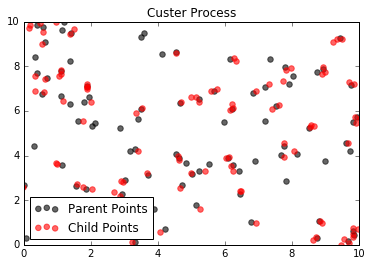

In [191]:
plt.figure()

plt.scatter(homog_pp[:,0], homog_pp[:,1], s=30, color='black', alpha=0.6, label="Parent Points")
plt.scatter(child_points[:,0], child_points[:,1], s=30, color='red', alpha=0.6, label="Child Points")

plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Custer Process")

plt.show()

## 1.4  Repulsive Process

For our final point process, consider the **Matern Model**.  Similarly to the cluster process, we'll sample from a homogeneous Poisson process and then perform a second-step involving the parent points.  This time, instead of adding points, we'll simply remove any points that occur within a distance $r$ of a previously sampled one.  Define *Matern($\lambda_{0}$, $r$)* as... 

$$ \{ u_{i} \} \sim Poisson \ Process(\lambda_{0}) $$
$$ \textbf{remove} \ \  u_{i} \ \ if  \ \ \mid \mid u_{i} - u_{j} \mid \mid_{2} \le r \ \ for \ any \ \ j < i$$

Now let's define the thinning method...

In [192]:
def thin_process(data, radius=.75):
    X = np.array(data)
    
    test_idx = X.shape[0]-1
    while test_idx > 0:
        for idx in range(test_idx):
            
            if np.sqrt(np.sum((X[test_idx] - X[idx])**2)) <= radius:
                X = np.delete(X, test_idx, 0)
                break  # we've found one point that satisfies, no need to test others
                
        test_idx -= 1
    return X

Let's sample from the process...

In [193]:
repulsed_process = thin_process(homog_pp)

Plot the original and final points...

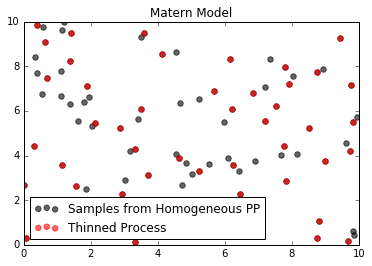

In [194]:
plt.figure()
plt.scatter(homog_pp[:,0], homog_pp[:,1], s=30, color='black', alpha=0.6, label="Samples from Homogeneous PP")
plt.scatter(repulsed_process[:,0], repulsed_process[:,1], s=30, color='red', alpha=0.6, label="Thinned Process")
plt.xlim([0,nX])
plt.ylim([0,nX])
plt.legend(loc=3)
plt.title("Matern Model")

plt.show()

# PART 2:  Testing Observed Data
--------------------

Having defined the above processes, now let's consider the scenario in which we have observed data and want to test if it originated from a homogeneous process, a clustering process, or a repellant process.  To do this, we'll use the **G function** (see *Baddeley 15.3.1*), which is defined as follows:

$$ G(\mathbf{X}, r) = \frac{1}{N_{X}} \sum_{i=1}^{N_{X}} \mathbb{1}[ t_{i} \le r ] $$

where $r$ is a distance parameter and $t_{i} = \min \mid \mid u_{i} - u_{j} \mid \mid_{2}$.  Or in words, $t_{i}$ is the distance from $u_{i}$ to its nearest neighbor.

Let's implement the G function...

In [195]:
def calculate_emp_G_statistic(data, radius=1.):
    
    n = data.shape[0]
    dist_tests = [0.] * n
    
    for i in range(n):
        for j in range(n):
            
            # skip if same point or if we already found the dist satisfied
            if i == j or dist_tests[j] == 1: continue 
            
            euc_dist = np.sqrt(np.sum((data[i] - data[j])**2))
            if euc_dist <= radius:
                dist_tests[i] = 1.
                dist_tests[j] = 1.
                break
                
    return np.sum(dist_tests)/n

If the data is truly from a Poisson process, the G statistic has an asymptotic form, given as follows 

$$ G_{poisson}(\lambda, r) = 1 - e^{-\lambda \pi r^{2}} .$$ 

We can use this formula for observed data if we use an empirical estimate for the intensity:

$$ \hat{\lambda} = \mid \mathbf{X} \mid / \mid \mathcal{X} \times \mathcal{Y} \mid $$ where $\mid \mathbf{X} \mid$ is the number of observations and $\mid \mathcal{X} \times \mathcal{Y} \mid$ is the volume of the space.

In [196]:
def calculate_emp_intensity(data):
    # assumes a square region
    return data.shape[0]/(np.max(data)-np.min(data))**2


def calculate_poisson_G_statistic(data, radius=1.):   
    
    # get emp. intensity
    emp_intensity = calculate_emp_intensity(data)        
    
    # asymptotic formula
    return 1 - np.exp(-emp_intensity * np.pi * radius**2)

Now let's calculate the empirical and asympotic G statistics for a range of $r$ values...

In [209]:
radii = np.arange(0., 1.1, .1)

g_data = []
g_poisson = []
for data in [homog_pp, cluster_process, repulsed_process]:
    
    # calculate G-function on data
    g_data.append([calculate_emp_G_statistic(data, radius=r) for r in radii])
    
    # calculate G-function as if the data were a homogeneous PP
    g_poisson.append([calculate_poisson_G_statistic(data, radius=r) for r in radii])

Plot the curves for each point process type...

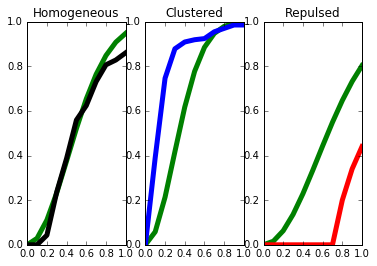

In [210]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.plot(radii, g_poisson[0],'g-', linewidth=5.)
ax1.plot(radii, g_data[0],'k-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.plot(radii, g_poisson[1],'g-', linewidth=5.)
ax2.plot(radii, g_data[1],'b-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Clustered")

ax3 = plt.subplot(1, 3, 3)
ax3.plot(radii, g_poisson[2],'g-', linewidth=5.)
ax3.plot(radii, g_data[2],'r-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Repulsed")

plt.show()

## 2.1  Monte Carlo Envelope Tests

While the above method---comparing empirical and asymptotic G-functions---suggests the processes characteristics, it doesn't provide a clear, stastically-sound decision, such as a hypothesis test would provide.  Here we perform such a test, called a *Monte Carlo Envelope Test* (see *Baddeley 16*).  **Note this is NOT a Neyman-Pearson confidence interval.**  Rather, the test is based off the [*Monte Carlo test principle*](https://perso.univ-rennes1.fr/jian-feng.yao/pedago/mcmc/Hope.pdf).  

These details aside, the procedure is as follows.  First, we decide on the number of replications based off our desired test level, according to the formula 

$$ \alpha = \frac{2}{M+1}. $$  Thus, if we desire the usual $\alpha = 0.05$, we need to perform $M=39$ replications.

In [211]:
### M=39 so that alpha = 0.05
n_replications = 39

Next we sample $M$ datasets $\mathbf{X}_{m}$, eaching containing the same number of data points as in the observation set, i.e. $$\mathbf{X}_{m} = \{x_{1},..., x_{n} \} \sim Uniform(\mid \mathcal{X} \times \mathcal{Y} \mid).$$  We then calculate the G-function for several $r$ values for each dataset, i.e. $ \hat{G}(\mathbf{X}_{m}, r)$.  Lastly, we find the extreme values of $\hat{G}(\mathbf{X}_{m}, r)$ (across $m$) for each radius value.  Mathematically, we have bounds $[L(r), U(r)]$ given by $$ L(r) = \min_{m} \  \hat{G}(\mathbf{X}_{m}, r) \ \ \ \text{ and } \ \ \  U(r) = \max_{m} \  \hat{G}(\mathbf{X}_{m}, r).$$

Let's implement the procedure...

In [216]:
g_maxs = []
g_mins = []

for data in [homog_pp, thinned_process, repulsed_process]:
    
    n = data.shape[0]
    
    temp_list = []
    # Calculate G stat under repeated sampling from PP with emp intensity
    for i in range(n_replications):
        temp_list.append([calculate_emp_G_statistic(np.random.uniform(low=0, high=nX, size=(n,2)), radius=r) for r in radii])

    # Compute mean and std of replications    
    temp_list = np.array( temp_list )
    g_maxs.append( np.max(temp_list, axis=0) )
    g_mins.append( np.min(temp_list, axis=0) )

Plot the results...

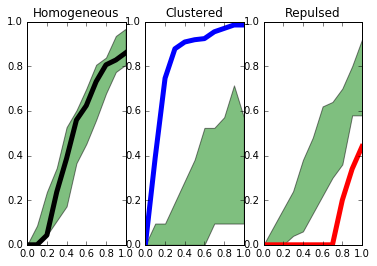

In [217]:
### Make Plots
ax1 = plt.subplot(1, 3, 1)
ax1.fill_between(radii, g_mins[0], g_maxs[0], facecolor='green', interpolate=True, alpha=.5)
#ax1.plot(radii, g_poisson_means[0],'g-', linewidth=5.)
ax1.plot(radii, g_data[0],'k-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Homogeneous")

ax2 = plt.subplot(1, 3, 2)
ax2.fill_between(radii, g_mins[1], g_maxs[1], facecolor='green', interpolate=True, alpha=.5)
#ax2.plot(radii, g_poisson_means[1],'g-', linewidth=5.)
ax2.plot(radii, g_data[1],'b-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Clustered")

ax3 = plt.subplot(1, 3, 3)
ax3.fill_between(radii, g_mins[2], g_maxs[2], facecolor='green', interpolate=True, alpha=.5)
#ax2.plot(radii, g_poisson_means[2],'g-', linewidth=5.)
ax3.plot(radii, g_data[2],'r-', linewidth=5.)
plt.xlim([0,1.])
plt.ylim([0,1.])
plt.title("Repulsed")

plt.show()

# PART 3:  Application to Protein Dataset
--------------------

